# Normalized Mean Hydrograph

__Description__: Calculates normalized mean hydrographs for the specified USGS Stream Gage and, optionally, creates the final fluvial forcing file.

__Input__: 
- The USGS Gage ID, a discharge threshold value, and filenames and paths.
- The *Sampler_Operation_.xlsx* for the specified USGS Stream Gage, which contains the production list of events. This Excel Workbook is created by the `PM_Sampler_Ops` Jupyter Notebook.
- The *Fluvial_Parameters.xlsx* which contains information on the fluvial model, including its run duration and time step.

## A. Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('..')
import os
import pathlib as pl
sys.path.append('..')
home = pl.Path(os.getcwd())

In [2]:
from src.modules.hydrographs import*
from src.modules.nb_libraries import*
from src.modules.fluvial_hydro import*
import baseflow.physep.hysep as hysep

### Parameters:
#### Site specific:

In [3]:
#get basin information
with open(home/'Inputs'/'huc12.txt','r') as tfile:
    huc12 = tfile.read()
with open(home/'Inputs'/'stream_gage.txt','r') as tfile:
    stream_gage = tfile.read()
    
export_forcing = True    # Specify whether you want to save the fluvial forcing (True) or export the normalized mean hydrographs for joint probability (False)
data_threshold = 0     # Q at 1.75 Return Period. This value can be identified from HEC-SSP analysis.

inputs_dir = home/'Inputs'/huc12
outputs_dir = home/'Outputs'/huc12
forcing_dir = outputs_dir/'{0}_Forcing'.format(stream_gage)
fluvial_params = {'Domain': ['main'],
                 'Run Duration (Days)':[5],
                 'Timestep (Minutes)':[5],
                 'Time Index Ordinate':['Hours']}

#### Project specific (global):

In [4]:
parameter = "00060"  # USGS discharge code

## Options
timestep = 5              # [minutes]; timestep
int_increment = 20        # Interpolation increment
fluvial_BC_units = 'cfs'  # The fluvial boundary condition units
verbose = True            # Option to display print statements

### Data:
#### Fluvial model parameters:

In [5]:
fm = pd.DataFrame.from_dict(fluvial_params).set_index('Domain')
fm.head(2)

,Run Duration (Days),Timestep (Minutes),Time Index Ordinate
Domain,,,
main,5,5,Hours


##### Extract the run duration and timestep:

In [6]:
run_dur, tstep, idx_ord = extract_fmodel_params(fm, 'main', 'Run Duration (Days)', 'Timestep (Minutes)', 'Time Index Ordinate', verbose)

Run duration: 5 days 
Timestep: 5 minutes 
Time index ordinate: Hours
Note: the run duration and timestep are assumed to have units of days and minutes, respectively


#### Explore all available flow data for the specified USGS station:

In [7]:
open_station_website(stream_gage)    

##### Using the USGS website, specify the start and end dates below:

In [51]:
start_date_of_record = "1990-10-01"  # Start of record
end_date_of_record = "2022-12-27"    # End of record

In [52]:
usgs_values = usgs_data(stream_gage, start_date_of_record, end_date_of_record, parameter)

In [53]:
usgs_values[0:2] #to confirm time increment. can make this a function later

[{'value': '79.0',
  'qualifiers': ['A', '[92]'],
  'dateTime': '1990-10-01T01:30:00.000-04:00'},
 {'value': '72.0',
  'qualifiers': ['A', '[92]'],
  'dateTime': '1990-10-01T02:00:00.000-04:00'}]

In [54]:
area = 45.8 # sq. miles
time_increment = 30 #min
urban_factor = 1 #1 follows formula in HYSEP manual could assume another value for urban areas.
size = (2*area**.2)*urban_factor
print(size)
size_per_time_increment = int(size*(60/time_increment)*24)
print(size_per_time_increment)

4.297373399702682
206


In [55]:
#write relevant data to txt file for R code in notebook 2
sd = start_date_of_record.replace('-','')
with open(home/'Outputs'/huc12/f'{stream_gage}_info.txt', 'w') as txt:
    txt.write(f'{area};{time_increment};{sd}')

#### Retrieve available data:

##### Format and subset the data to include only events greater than the threshold, and plot:

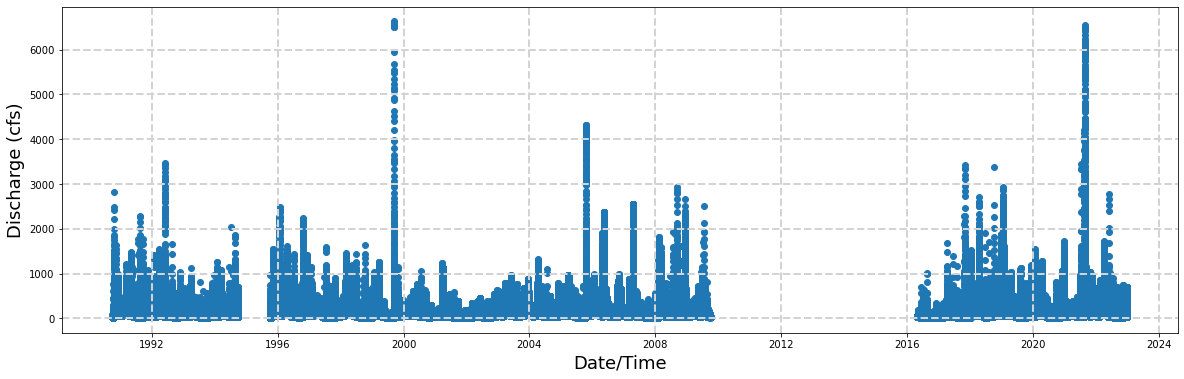

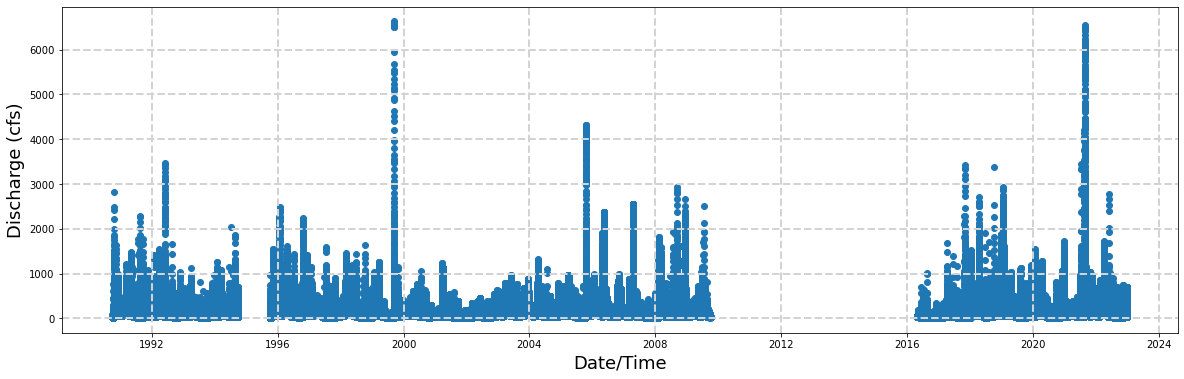

In [56]:
df, dfslice = usgs_to_sliced_df(usgs_values, data_threshold)

plot_scatter(df['dateTime'], y = df['flow'])

plot_scatter(dfslice['dateTime'], y = dfslice['flow'])

#### Hydrograph Seperation Using HySep

In [57]:
dataQ = pd.Series(df['flow'].values, df['dateTime'].values )
b, q = hysep.local_minimum_filter(dataQ, size_per_time_increment)
#plt.plot(dataQ)
#plt.plot(b)
#plt.show()

hello world
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([36]), array([], dtype=int64), array([], dtype=int64), array([12]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), a

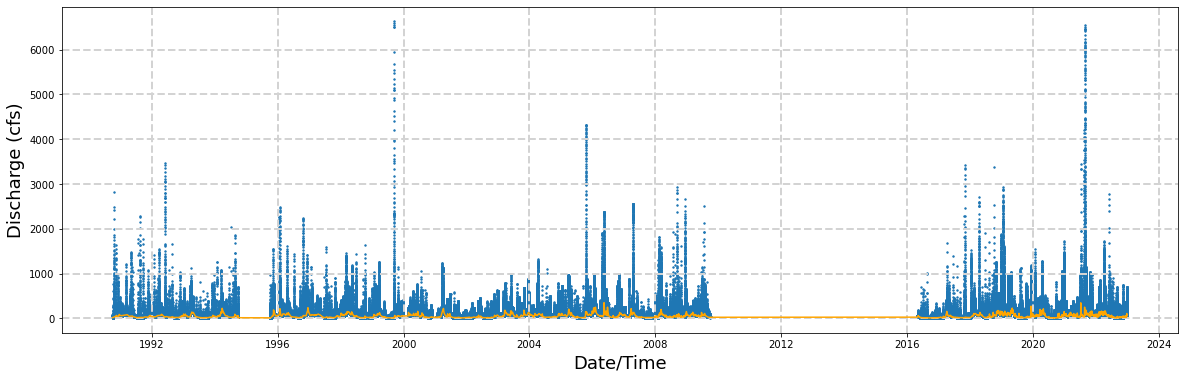

In [58]:
plot_scatter_sep(df['dateTime'], y = df['flow'], y2=b)

##### Transfer the sliced dataframe into a dictionary and plot the hydrographs:

In [59]:
df_out=df.copy()
df_b = pd.DataFrame(data=b)
array_b=df_b['baseflow'].astype(float).to_numpy()
df_out['baseflow']=array_b.tolist()
df_out.to_csv(outputs_dir/f'USGS_{stream_gage}.csv')

In [60]:
dataQ.iloc[0:72].sum()

2506.0

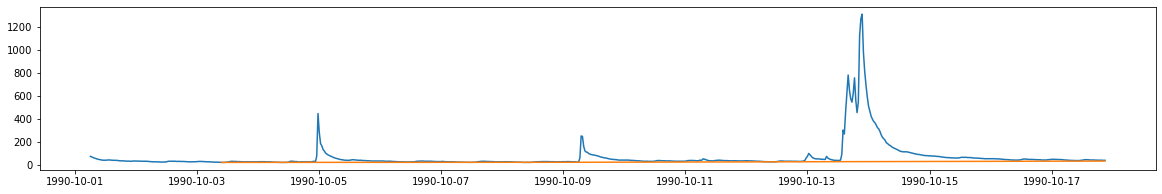

In [61]:
block = 0
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(dataQ[1+block:800+block])
plt.plot(b[1+block:800+block])
plt.show()

---
## End